### Useful Resources

- [A Practical Guide to LambdaMART in LightGbm](https://medium.datadriveninvestor.com/a-practical-guide-to-lambdamart-in-lightgbm-f16a57864f6)
- [lightgbm.LGBMRanker Documentation](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRanker.html#)
- [LightGBM Parameter Tuning Guide](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
- [How To Use Optuna to Tune LightGBM Hyperparameters](https://forecastegy.com/posts/how-to-use-optuna-to-tune-lightgbm-hyperparameters/)
- [Optuna](https://optuna.readthedocs.io/en/stable/tutorial/index.html)

### Global Constants

In [1]:
# --------------- Model --------------- #
# k for NDCG@k
K = 5    
# Number of iterations/trees for LightGBM              
NUM_ITERATIONS = 2000 # 1000

# --------------- Tuning --------------- #
# number of trials for Optuna
N_TRIALS = 10   # 30   

### Libraries

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import pickle

import psutil
import os
from pathlib import Path
from datetime import datetime
import json

from data import read_processed_train, read_processed_val, read_processed_test

/Users/nathanjones/Development/VU/DMT/dmt_recom_sys/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read Data

In [3]:
train_df = read_processed_train()

In [4]:
val_df = read_processed_val()

In [5]:
test_df = read_processed_test()

### Change Target

**Function Definitions**
- Take in train_df or val_df and modify the target column
- All columns can be used
- Do not change the row order
- **target must be an integer**

In [6]:
def base_target(df):
    """
    Applies the weighting given in the assignment (no discounting)
    """
    df['target'] = 0

    mask = df['click_bool'] == 1
    df.loc[mask, 'target'] = 1

    mask = df['booking_bool'] == 1
    df.loc[mask, 'target'] = 5

    return df

In [ ]:
# Add others...

**Apply Functions**

- Apply one of the above functions to train_df and val_df

In [7]:
# Choice of target function
target_func = base_target

# ---------------------------------- #

# Apply target function
train_df = target_func(train_df)
val_df = target_func(val_df)

### Feature Engineering

**Function Defintions**
- Take in a dataframe and modify/add columns
- Must be applicable to train_df, val_df and test_df
- Do not change the row order

In [8]:
def hour_day_month_year(df):
    """
    Function to create day, month, year columns from date_time column.
    """
    df['date_time'] = pd.to_datetime(df['date_time'])

    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day
    df['month'] = df['date_time'].dt.month
    df['year'] = df['date_time'].dt.year

    return df

In [9]:
# Features that will receive a rank column
ranked_cols = ['prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'price_usd', 'orig_destination_distance']

def add_ranks(df):
    """
    Function to add rank of certain features within each srch_id. Values are
    ranked in ascending order, with ties receiving the same rank.
    """
    for ranked_col in ranked_cols:
        df[f'{ranked_col}_rank'] = df.groupby('srch_id')[ranked_col].rank(method='dense')
    
    return df

In [10]:
def starrating_review_diff(df):
    """
    Function to create absolute difference between 'prop_starrating' and 'prop_review_score'.
    """
    df['starrating_review_diff'] = abs(df['prop_starrating'] - df['prop_review_score'])
    
    return df

In [11]:
def sum_adults_children(df):
    """
    Function to create sum of adults and children counts
    """
    df['sum_adults_children'] = df['srch_adults_count'] + df['srch_children_count']
    
    return df

In [12]:
# Estimate click and booking probability for each property

# Join train and val sets
train_val_df = pd.concat([train_df, val_df], ignore_index=True)

# Probability of click and book for each prop_id
train_val_df['click_prob'] = train_val_df.groupby('prop_id')['click_bool'].transform('mean')
train_val_df['booking_prob'] = train_val_df.groupby('prop_id')['booking_bool'].transform('mean')

# Create lookup tables
prob_lookup = train_val_df[['prop_id', 'click_prob', 'booking_prob']].drop_duplicates().set_index('prop_id')

def add_probabilities(df):
    """
    Function to add click and booking probabilities to each row. Unseen prop_ids
    are given -1.
    """
    df = df.join(prob_lookup, on='prop_id')
    df[['click_prob', 'booking_prob']] = df[['click_prob', 'booking_prob']].fillna(-1)
    
    return df

In [ ]:
# Add others...

**Apply Functions**

- Apply some combination of the above functions to train_df, val_df and test_df

In [13]:
# List of functions to apply in order
feature_functions = [hour_day_month_year, add_ranks, starrating_review_diff, sum_adults_children, add_probabilities]

# ---------------------------------- #

# Apply listed functions
for func in feature_functions:
    train_df = func(train_df)
    val_df = func(val_df)
    test_df = func(test_df)

### Final Data Preparation

Specify categorical variables

In [14]:
all_cat_cols = ['site_id', 'visitor_location_country_id', 'prop_country_id', 'prop_starrating', 'prop_brand_bool', 'promotion_flag', 'srch_destination_id', 'srch_saturday_night_bool', 'random_bool', 'month', 'year']

In [15]:
def specify_categorical(df):
    """
    Function to explicitly specify categorical variables.
    """
    df_cols = list(df.columns)

    for col in df_cols:
        if col in all_cat_cols:
            df[col] = df[col].astype('category')
    
    return df

In [16]:
train_df = specify_categorical(train_df)
val_df = specify_categorical(val_df)
test_df = specify_categorical(test_df)

Removing unwanted columns and preparing the data for the model

In [17]:
# Specify additional columns to remove
add_drop_cols = ['srch_id', 'date_time', 'prop_id']

# ---------------------------------- #

# Remove columns that won't be used as features
train_only_cols = ['position', 'click_bool', 'booking_bool', 'target'] + add_drop_cols

# Train data
group_train = train_df.groupby("srch_id")["srch_id"].count().to_numpy()
X_train = train_df.drop(columns=train_only_cols)
y_train = train_df['target'].astype(int)

# Validation data
group_val = val_df.groupby("srch_id")["srch_id"].count().to_numpy()
X_val = val_df.drop(columns=train_only_cols)
y_val = val_df['target'].astype(int)

# Test data
X_test = test_df.drop(columns=add_drop_cols).to_numpy(copy=True)

### Tuning

In [ ]:
# Create the folder to store the results of the tuning
tune_folder_path = Path("./tuned_models/" + datetime.now().strftime("%Y%m%d_%H%M%S"))
tune_folder_path.mkdir(parents=True, exist_ok=True)

Constant hyperparameters

In [ ]:
const_params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "ndcg",
    "n_estimators": NUM_ITERATIONS,
    'max_depth': -1,
    "importance_type": "gain",
    "label_gain": [i for i in range(max(y_train.max(), y_val.max()) + 1)],
    "bagging_freq": 1,
    "n_jobs": psutil.cpu_count(logical=False) - 1,
    "verbosity": -1,
    # new params
    # "early_stopping_round": int(NUM_ITERATIONS/10),  # stops if 10% of iterations val score doesn't improve
    }

Define the objective

Changes:
- num_leaves [10, 25]

In [ ]:
def objective(trial):
    tuned_params = {
        "num_leaves": trial.suggest_int("num_leaves", 10, 25),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 5000),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.01, 1, log=True),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.9),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.01, 0.5),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 5),
    }

    params = const_params | tuned_params

    model = lgb.LGBMRanker(**params)
    model.fit(
        X=X_train,
        y=y_train,
        group=group_train,
        eval_set=[(X_train, y_train),(X_val, y_val)],
        eval_group=[group_train, group_val],
        eval_at=[K], # k for NDCG@k
        verbose=False,
      )
    
    # Save the trained model
    with open(tune_folder_path / f"trial_{trial.number}.pkl", "wb") as f:
        pickle.dump(model, f)

    best_val_score = model.best_score_['valid_1'][f'ndcg@{K}']
    return best_val_score

Optimise the objective

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

Save the results

In [ ]:
# Keep only the best model (and rename it)
for trial in study.trials:
    if trial.number != study.best_trial.number:
        os.remove(tune_folder_path / f"trial_{trial.number}.pkl")
    else:
        os.rename(tune_folder_path / f"trial_{trial.number}.pkl", tune_folder_path / "best_model.pkl")

In [ ]:
# Save the best hyperparameters
with open(tune_folder_path / "best_params.json", "w") as f:
    best_params = const_params | study.best_params
    json.dump(best_params, f)

# Save some other relevant information
with open(tune_folder_path / "info.txt", "w") as f:
    f.write(f"{10 * '-'} Global constants {10 * '-'}\n\n")
    f.write(f"NUM_ITERATIONS = {NUM_ITERATIONS}\n")
    f.write(f"K = {K}\n")
    f.write(f"N_TRIALS = {N_TRIALS}\n\n")
    f.write(f"{10 * '-'} Features {10 * '-'}\n\n")
    f.write(f"{list(X_train.columns)}\n\n")
    f.write(f"{10 * '-'} Study Info {10 * '-'}\n\n")
    f.write(f"Best value: {study.best_value}\n")
    f.write(f"Best trial number: {study.best_trial.number}\n")

In [ ]:
# Add plots

### Training

**Load the model (choose one)**

1. Create a new model with hand-picked hyperparameters

In [ ]:
params = {
        # Constant parameters
        "objective": "lambdarank",
        "boosting_type": "gbdt",
        "metric": "ndcg",
        "n_estimators": NUM_ITERATIONS, 
        "importance_type": "gain",
        "label_gain": [i for i in range(max(y_train.max(), y_val.max()) + 1)],
        "bagging_freq": 1,
        "n_jobs": psutil.cpu_count(logical=False),
        "verbosity": -1,
        # Tuning parameters
        "num_leaves": 32,
        'max_depth': -1,
        "learning_rate": 0.01,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "min_data_in_leaf": 50,
    }

model = lgb.LGBMRanker(**params)

2. Create a new model with the most recently tuned hyperparamters

In [ ]:
root = Path("./tuned_models")
most_recent_dir = [str(d)[-15:] for d in sorted(root.iterdir()) if d.is_dir()][-1]

with open(root / most_recent_dir / "best_params.json", "r") as f:
    best_params = json.load(f)

model = lgb.LGBMRanker(**best_params)

3. Load the best model from the most recent tuning process

In [ ]:
root = Path("./tuned_models")
most_recent_dir = [str(d)[-15:] for d in sorted(root.iterdir()) if d.is_dir()][-1]
model_path = root / most_recent_dir / "best_model.pkl"

model = pickle.load(open(model_path, "rb"))

4. Custom

In [18]:
# Create a lgb.LGBMRanker model however you like
root = Path("./tuned_models")
most_recent_dir = [str(d)[-15:] for d in sorted(root.iterdir()) if d.is_dir()][-1]

with open(root / most_recent_dir / "best_params.json", "r") as f:
    best_params = json.load(f)

# model = lgb.LGBMRanker(**best_params)
best_params['n_estimators'] = 2000
# best_params.pop('early_stopping_round')
model = lgb.LGBMRanker(**best_params)
best_params

{'objective': 'lambdarank',
 'boosting_type': 'gbdt',
 'metric': 'ndcg',
 'n_estimators': 2000,
 'max_depth': -1,
 'importance_type': 'gain',
 'label_gain': [0, 1, 2, 3, 4, 5],
 'bagging_freq': 5,
 'n_jobs': 1,
 'verbosity': -1,
 'num_leaves': 24,
 'learning_rate': 0.009351651818696535,
 'min_data_in_leaf': 4098,
 'min_gain_to_split': 0.14839470109519814,
 'bagging_fraction': 0.5268156263932648,
 'feature_fraction': 0.43332987948727686}

**Fitting the model** (skip if using a trained model)

In [19]:
model.fit(
      X=X_train,
      y=y_train,
      group=group_train,
      eval_set=[(X_train, y_train),(X_val, y_val)],
      eval_group=[group_train, group_val],
      eval_at=[K] # k for NDCG@k
      )

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=4098, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4098
[LightGBM] [Warning] min_gain_to_split is set=0.14839470109519814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14839470109519814
[LightGBM] [Warning] feature_fraction is set=0.43332987948727686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43332987948727686
[LightGBM] [Warning] bagging_fraction is set=0.5268156263932648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268156263932648


/Users/nathanjones/Development/VU/DMT/dmt_recom_sys/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/nathanjones/Development/VU/DMT/dmt_recom_sys/venv/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's ndcg@5: 0.542613	valid_1's ndcg@5: 0.390132
[2]	training's ndcg@5: 0.55764	valid_1's ndcg@5: 0.406339
[3]	training's ndcg@5: 0.56701	valid_1's ndcg@5: 0.417409
[4]	training's ndcg@5: 0.570511	valid_1's ndcg@5: 0.419321
[5]	training's ndcg@5: 0.570956	valid_1's ndcg@5: 0.420935
[6]	training's ndcg@5: 0.575201	valid_1's ndcg@5: 0.424575
[7]	training's ndcg@5: 0.576992	valid_1's ndcg@5: 0.425651
[8]	training's ndcg@5: 0.574621	valid_1's ndcg@5: 0.424212
[9]	training's ndcg@5: 0.573654	valid_1's ndcg@5: 0.423236
[10]	training's ndcg@5: 0.57405	valid_1's ndcg@5: 0.424017
[11]	training's ndcg@5: 0.576823	valid_1's ndcg@5: 0.427897
[12]	training's ndcg@5: 0.580823	valid_1's ndcg@5: 0.432056
[13]	training's ndcg@5: 0.58089	valid_1's ndcg@5: 0.431801
[14]	training's ndcg@5: 0.581012	valid_1's ndcg@5: 0.43239
[15]	training's ndcg@5: 0.582417	valid_1's ndcg@5: 0.433647
[16]	training's ndcg@5: 0.581661	valid_1's ndcg@5: 0.433181
[17]	training's ndcg@5: 0.580534	valid_1's ndcg@5: 0.4

LGBMRanker(bagging_fraction=0.5268156263932648, bagging_freq=5,
           feature_fraction=0.43332987948727686, importance_type='gain',
           label_gain=[0, 1, 2, 3, 4, 5], learning_rate=0.009351651818696535,
           metric='ndcg', min_data_in_leaf=4098,
           min_gain_to_split=0.14839470109519814, n_estimators=2000, n_jobs=1,
           num_leaves=24, objective='lambdarank', verbosity=-1)

### Plots

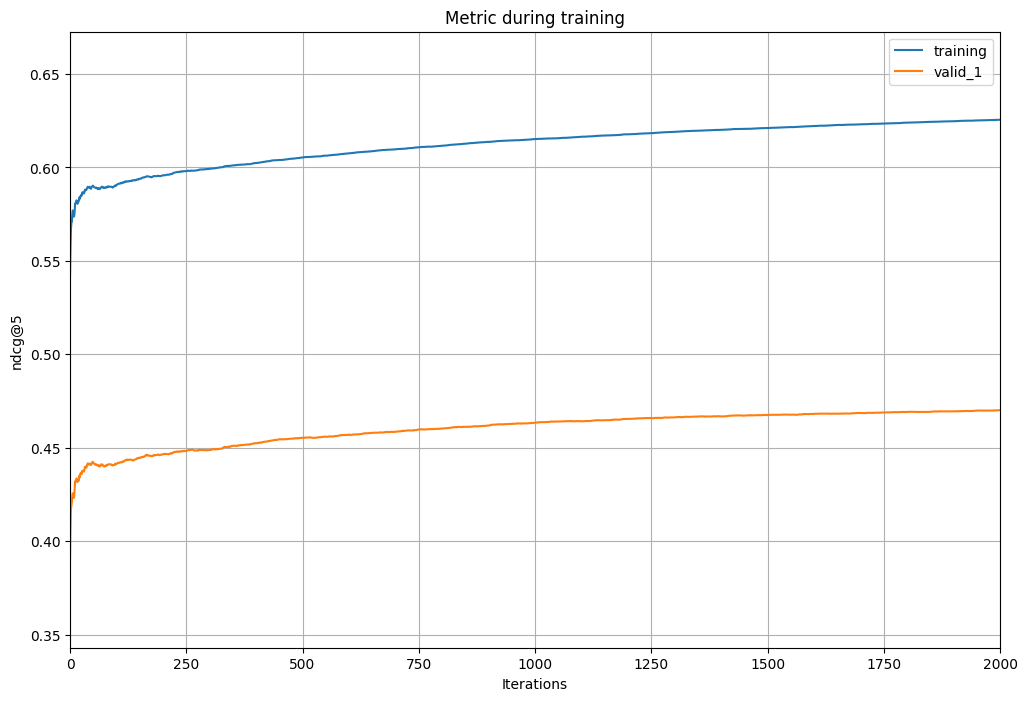

In [20]:
ax_metric = lgb.plot_metric(model, figsize = (12,8))

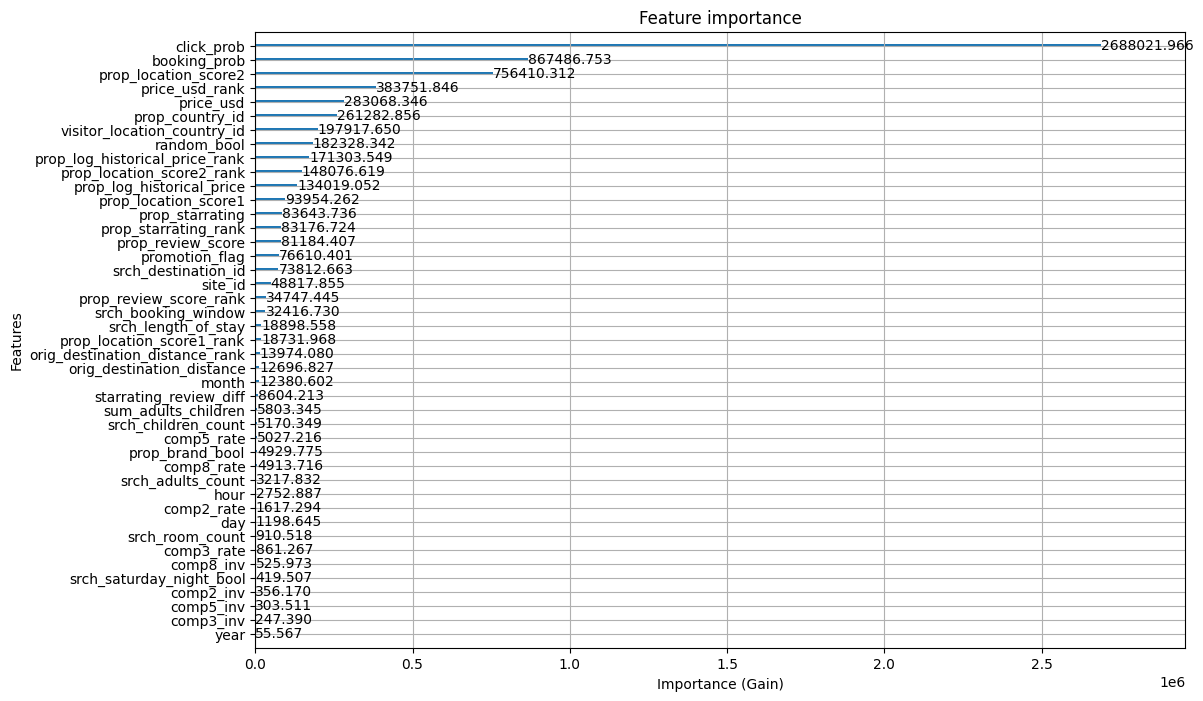

In [21]:
ax_importance = lgb.plot_importance(model, xlabel='Importance (Gain)', figsize = (12,8))

### Testing

In [22]:
prediction = model.predict(X_test)
test_df['prediction'] = prediction
test_df = test_df.sort_values(by=['srch_id', 'prediction'], ascending=[True, False])

### Save Results

In [23]:
# Create the folder to store the results of the training
train_folder_path = Path("./trained_models/" + datetime.now().strftime("%Y%m%d_%H%M%S"))
train_folder_path.mkdir(parents=True, exist_ok=True)

# Save the model
pickle.dump(model, open(train_folder_path / "model.pkl", "wb"))

# Save the parameters
with open(train_folder_path / "params.txt", "w") as f:
    f.write(json.dumps(model.get_params()))

# Save the feature names
with open(train_folder_path / "feature_names.txt", "w") as f:
    f.write(str(list(X_train.columns)))

# Save the figures
ax_metric.figure.savefig(train_folder_path / "learning_curve.pdf", bbox_inches="tight")
ax_importance.figure.savefig(train_folder_path / "feature_importance.pdf", bbox_inches="tight")

# Save best evaluation scores
with open(train_folder_path / "best_scores.txt", "w") as f:
    f.write("Best training score: " + str(model.best_score_['training'][f'ndcg@{K}']) + "\n")
    f.write("Best validation score: " + str(model.best_score_['valid_1'][f'ndcg@{K}']) + "\n")

# Save the submission file
submission_file = train_folder_path / "submission.csv"
test_df[['srch_id', 'prop_id']].to_csv(submission_file, index=False)

### Playground

In [ ]:
x = {"a": 1, "b": 2}
y = {"c": 3, "d": 4}

x | y